# Problem statement
 To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Importing required libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
%matplotlib inline

# Importing dataset

In [2]:
#cloning github repository to make image files available
!git clone https://github.com/JPS-1984/CNN-Melanoma-Detection-Assignment.git

Cloning into 'CNN-Melanoma-Detection-Assignment'...
remote: Enumerating objects: 2300, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2300 (delta 0), reused 3 (delta 0), pack-reused 2297 (from 2)
Receiving objects: 100% (2300/2300), 752.55 MiB | 34.50 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Updating files: 100% (2361/2361), done.


In [3]:
#checking if we are running with a GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Reading data

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/CNN-Melanoma-Detection-Assignment/images/train")
data_dir_test = pathlib.Path("/content/CNN-Melanoma-Detection-Assignment/images/test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Dataset Creation

In [6]:
#Defining some parameters for the loader to create dataset
batch_size = 32
img_height = 180
img_width = 180


In [7]:
#Using 80% of images for training and 20% for validation
#cretaing training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
#creating validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


# Data Visualization

In [9]:
#Adding all classes of cancers available in dataset to a list.
#class_names attribute of the dataset will give all class names.
#These class names correspond to the directory names from dataset.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


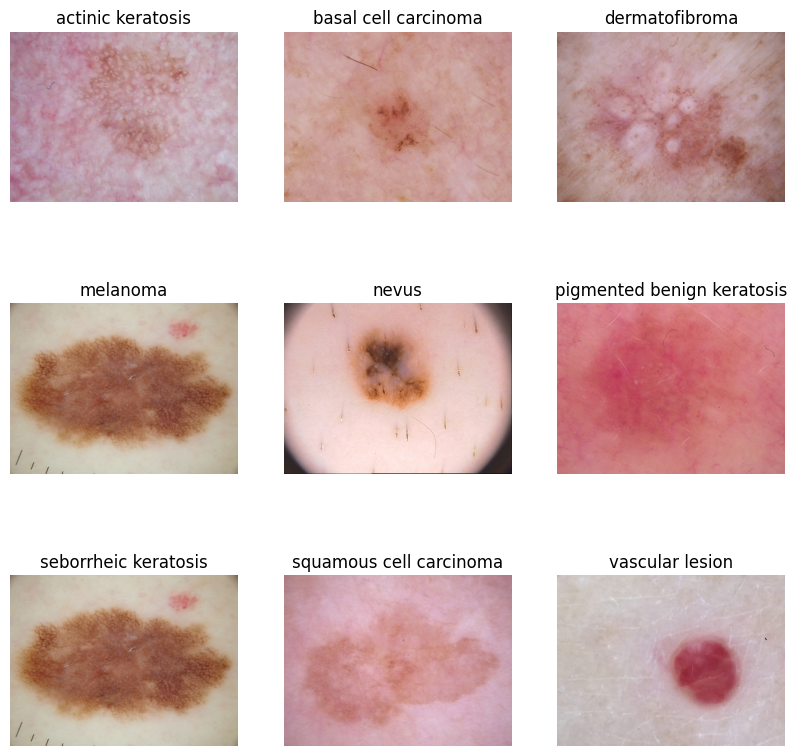

In [10]:
#visualizing the different classes of skin cancer images present in the training dataset
plt.figure(figsize=(10,10))
for i in range(len(class_names)):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[0]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

In [11]:
#Optimizing performance of data pipeline for both training and validation dataset
#Autotune is used to dynamically tune the behavior of the data pipeline
AUTOTUNE = tf.data.experimental.AUTOTUNE
"""
cache method caches the dataset in memory. It avoids redundant loading of images
from disk
shuffle helps to shffle the elements of the dataset using a buffer size of 1000
prefetch fetches the data upfront in the background while model is training
"""
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building and Training

### utility functions for model training and visualization

In [12]:
def train_model(model, train_ds, val_ds, epochs=20):
    """
    Trains a given CNN model.

    Args:
        model: The CNN model to train.
        train_ds: The training dataset.
        val_ds: The validation dataset.
        epochs: The number of epochs to train for.

    Returns:
        The training history.
    """

    # defining callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1, mode='auto')

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[reduce_lr]
    )
    return history


In [13]:
def visualize_trained_model(model, epochs=20):
    """
    Visualizes a given trained model.

    Args:
        model: The trained CNN model.
        epochs: The number of epochs that model was trained for.

    """

    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


In [37]:
#Model creation
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(9,activation='softmax'))

In [38]:
#Model compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [39]:
#Viewing model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,955,529 (60.87 MB)

 Trainable params: 15,955,529 (60.87 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
#Training the model
trained_model = train_model(model, train_ds, val_ds)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.2104 - loss: 2.5091 - val_accuracy: 0.3691 - val_loss: 1.8294 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3284 - loss: 1.7874 - val_accuracy: 0.4676 - val_loss: 1.5886 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4744 - loss: 1.4803 - val_accuracy: 0.5078 - val_loss: 1.4231 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5170 - loss: 1.3723 - val_accuracy: 0.5190 - val_loss: 1.3855 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5427 - loss: 1.2769 - val_accuracy: 0.5190 - val_loss: 1.4109 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6016 - loss: 1.1785 - val_accuracy: 0.5369 - val_loss: 1.3466 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6287 - loss: 1.0046 - val_acc

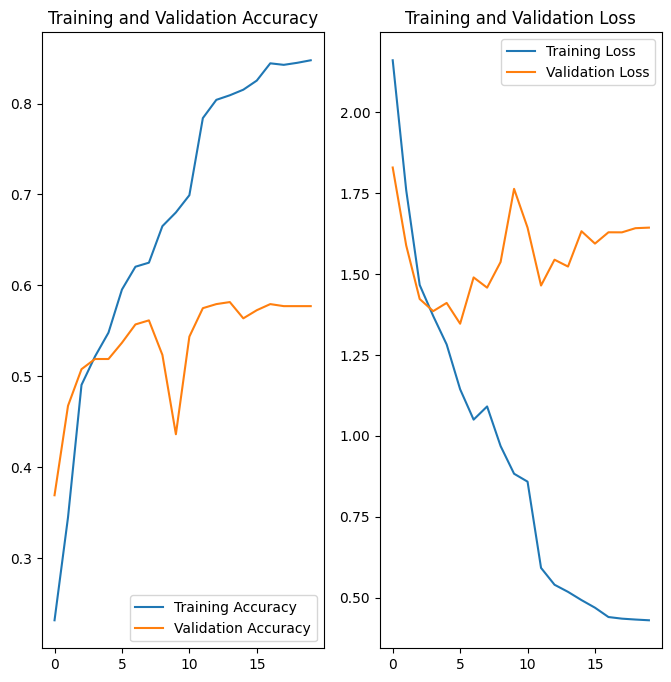

In [41]:
#Visulaizing training result
visualize_trained_model(trained_model)

# Findings after fitting the model
  - Training accuracy is around 84%
  - Validation accuracy lingered around 55%
  - Training loss follows a downward trend for the supplied epochs
  - Validation loss and Training loss has huge gap


# Conclusion
  - Training accuracy is quite high in comparison to validation
  accuracy
  - Model fit is not good; it is clearly overfitted

In [42]:
#Introducing dropouts in the model
#Model creation
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(9,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
#Model compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [44]:
#Viewing model summary
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,955,529 (60.87 MB)

 Trainable params: 15,955,529 (60.87 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
trained_model = train_model(model, train_ds, val_ds)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.1730 - loss: 3.9705 - val_accuracy: 0.2058 - val_loss: 2.1317 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.1979 - loss: 2.0442 - val_accuracy: 0.1924 - val_loss: 2.0461 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2039 - loss: 2.0233 - val_accuracy: 0.2685 - val_loss: 2.0160 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.3283 - loss: 1.8495 - val_accuracy: 0.4474 - val_loss: 1.7167 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4307 - loss: 1.6138 - val_accuracy: 0.5101 - val_loss: 1.4723 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4852 - loss: 1.4517 - val_accuracy: 0.5101 - val_loss: 1.4674 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5198 - loss: 1.3803 - val_acc

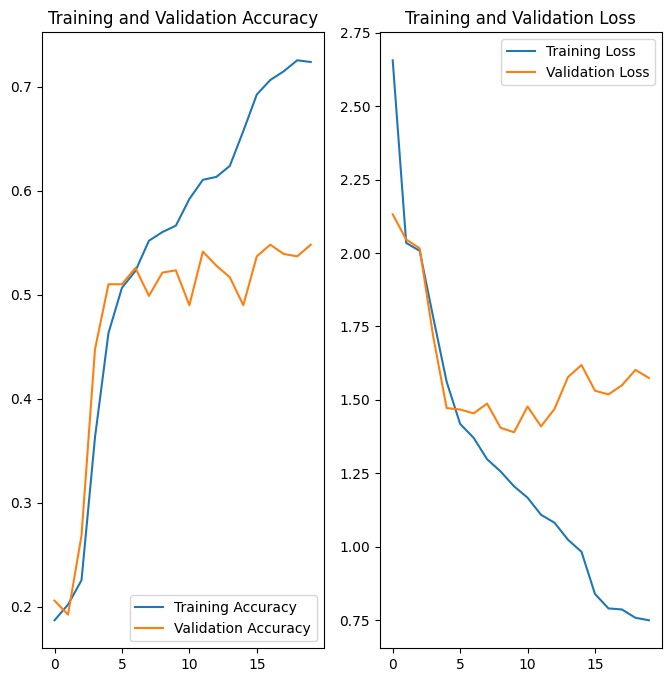

In [46]:
visualize_trained_model(trained_model)

# Observations after introducing dropouts
- Gap between training and validation accurancy has been reduced
- But, gap between training and validation loss is still high

# Data augmentation to resolve model issues

In [47]:
augmentated_data_model = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

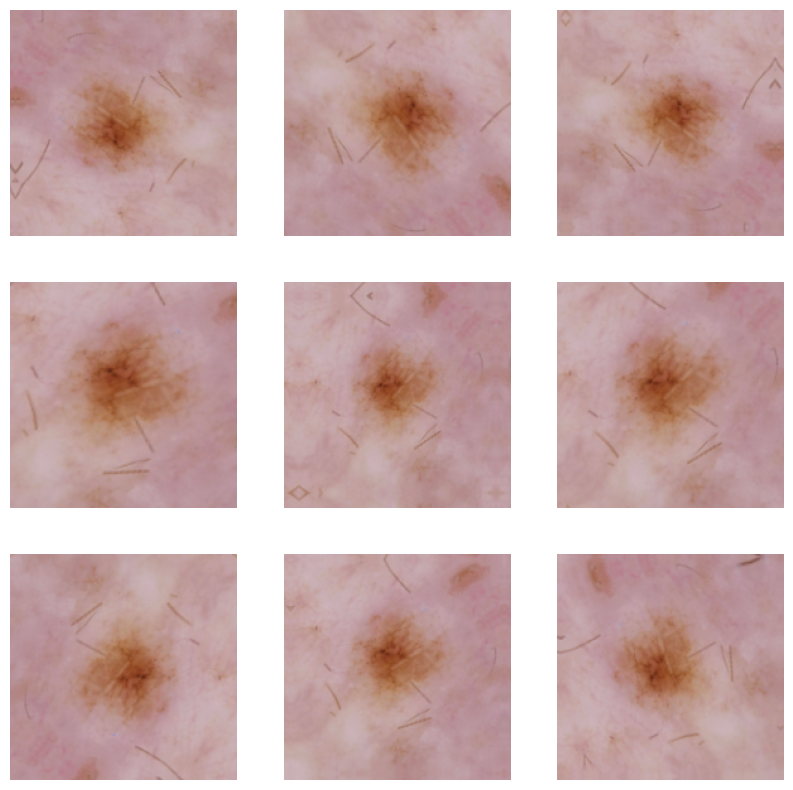

In [48]:
#visulaizing images in augmentated data
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = augmentated_data_model(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model Building and training on augmentated data

In [49]:
#Model creation with augmentated data
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(augmentated_data_model)
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(9,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [50]:
#Model compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [51]:
#Viewing model summary
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_8 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,955,529 (60.87 MB)

 Trainable params: 15,955,529 (60.87 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
#Training the model
post_aug_trained_model = train_model(model, train_ds, val_ds, 25)

Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.1673 - loss: 4.8558 - val_accuracy: 0.2461 - val_loss: 2.0208 - learning_rate: 0.0010
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.3375 - loss: 1.8456 - val_accuracy: 0.4072 - val_loss: 1.6978 - learning_rate: 0.0010
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.4095 - loss: 1.6903 - val_accuracy: 0.4631 - val_loss: 1.6878 - learning_rate: 0.0010
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.4234 - loss: 1.5941 - val_accuracy: 0.3893 - val_loss: 1.7183 - learning_rate: 0.0010
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.4565 - loss: 1.5623 - val_accuracy: 0.4564 - val_loss: 1.5597 - learning_rate: 0.0010
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.4598 - loss: 1.5169 - val_accuracy: 0.4676 - val_loss: 1.6052 - learning_rate: 0.0010
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.4772 - loss: 1.4970 - val_acc

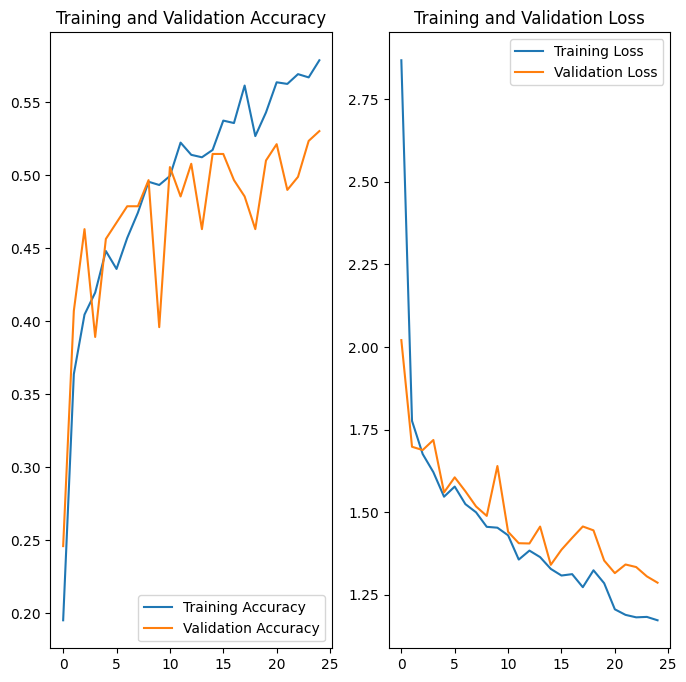

In [53]:
#Visulaizing training result
visualize_trained_model(post_aug_trained_model, 25)

# Observations after data augmentation
- Gap between training and validation accuracy is reduced
- Gap between training and validation loss is also reduced

# Conclusion
- Model seems to be working. But, accuracy is less
- We will try to find if there is any class imbalance and address it. Afterwards, we will recreate the model

# Class distribution

In [54]:
# Examining class distribution for images in dataset
class_df=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_df = pd.concat([class_df, pd.DataFrame({'class': [name], 'number': [number]})], ignore_index=True)

class_df

,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<function matplotlib.pyplot.show(close=None, block=None)>

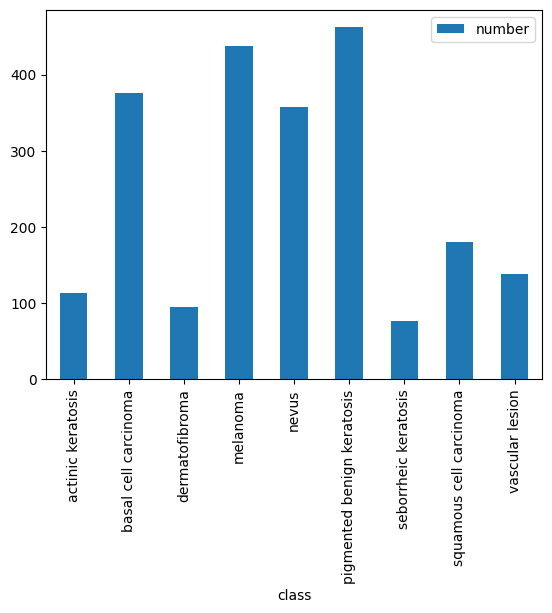

In [55]:
class_df.plot.bar(x='class',y='number',rot=90)
plt.show

# Conclusion from class distribution
- Clearly, there is data imbalance. Images from 'seborrheic keratosis' are quite less in comparison to images from 'pigmented benign keratosis'
- 'seborrheic keratosis' class has the least number of image samples
- 'pigmented benign keratosis' has the largest number of image samples

# Handling class imbalance

In [56]:
!pip install Augmentor

In [57]:
path_to_training_dataset="/content/CNN-Melanoma-Detection-Assignment/images/train/"
import Augmentor
for i in class_names:
    pipes = Augmentor.Pipeline(path_to_training_dataset + i)
    pipes.flip_left_right(0.5)
    pipes.random_distortion(1, 10, 10, 1)
    pipes.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    pipes.skew(0.25, 0.5)
    pipes.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/CNN-Melanoma-Detection-Assignment/images/train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD1EA315C10>: 100%|██████████| 500/500 [00:34<00:00, 14.44 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/CNN-Melanoma-Detection-Assignment/images/train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD1EE0958D0>: 100%|██████████| 500/500 [00:28<00:00, 17.62 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/CNN-Melanoma-Detection-Assignment/images/train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD1EA126E10>: 100%|██████████| 500/500 [00:29<00:00, 17.04 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/CNN-Melanoma-Detection-Assignment/images/train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=722x542 at 0x7FD1EA333E50>: 100%|██████████| 500/500 [02:42<00:00,  3.07 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/CNN-Melanoma-Detection-Assignment/images/train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1019x717 at 0x7FD1EE930B90>: 100%|██████████| 500/500 [02:40<00:00,  3.12 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/CNN-Melanoma-Detection-Assignment/images/train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD1EE00AD10>: 100%|██████████| 500/500 [00:28<00:00, 17.75 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/CNN-Melanoma-Detection-Assignment/images/train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD1EAD22750>: 100%|██████████| 500/500 [01:13<00:00,  6.76 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/CNN-Melanoma-Detection-Assignment/images/train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD1EAE5CED0>: 100%|██████████| 500/500 [00:28<00:00, 17.76 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/CNN-Melanoma-Detection-Assignment/images/train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD1EA31B9D0>: 100%|██████████| 500/500 [00:28<00:00, 17.43 Samples/s]


In [58]:
#Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.
#Lets take a look at total count of augmented images.
output_image_count = len(list(data_dir_train.glob('*/output/*.jpg')))
print(output_image_count)

4500


In [59]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[0]

'/content/CNN-Melanoma-Detection-Assignment/images/train/vascular lesion/output/vascular lesion_original_ISIC_0029448.jpg_2895f81a-4d90-45ba-9323-8095a97fb5af.jpg'

In [60]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[0]

'vascular lesion'

In [61]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [62]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([class_df, df2])

In [63]:
new_df['Label'].value_counts()

,count
Label,
vascular lesion,500
pigmented benign keratosis,500
basal cell carcinoma,500
seborrheic keratosis,500
squamous cell carcinoma,500
dermatofibroma,500
melanoma,500
actinic keratosis,500
nevus,500


In [64]:
for i in class_names:
    directory_out =path_to_training_dataset+i+'/output/'
    class_directory = pathlib.Path(path_to_training_dataset)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


# Creating training and valiation dataset after using augmentor

In [65]:
#creating validation set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [66]:
#creating validation set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [67]:
#Model creation after using augmentor to generate more data
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(9,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
#Model compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [69]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,955,529 (60.87 MB)

 Trainable params: 15,955,529 (60.87 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
#train the model
trained_model_post_augmentor = train_model(model, train_ds, val_ds, 40)

Epoch 1/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - accuracy: 0.1126 - loss: 4.1121 - val_accuracy: 0.1991 - val_loss: 2.0937 - learning_rate: 0.0010
Epoch 2/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.1679 - loss: 2.1100 - val_accuracy: 0.3826 - val_loss: 1.8430 - learning_rate: 0.0010
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.2891 - loss: 1.8557 - val_accuracy: 0.3602 - val_loss: 1.7693 - learning_rate: 0.0010
Epoch 4/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.3265 - loss: 1.7567 - val_accuracy: 0.4094 - val_loss: 1.6692 - learning_rate: 0.0010
Epoch 5/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.3526 - loss: 1.7644 - val_accuracy: 0.4966 - val_loss: 1.5914 - learning_rate: 0.0010
Epoch 6/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.4295 - loss: 1.5301 - val_accuracy: 0.4989 - val_loss: 1.5255 - learning_rate: 0.0010
Epoch 7/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.4073 - loss: 1.5786 - 

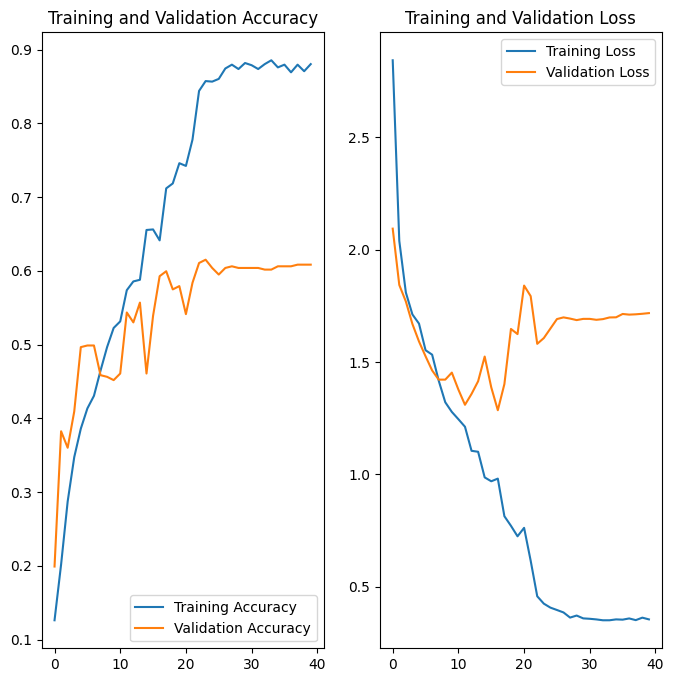

In [71]:
visualize_trained_model(trained_model_post_augmentor, 40)

# Testing the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
Actual Class: basal cell carcinoma
Predictive Class: actinic keratosis


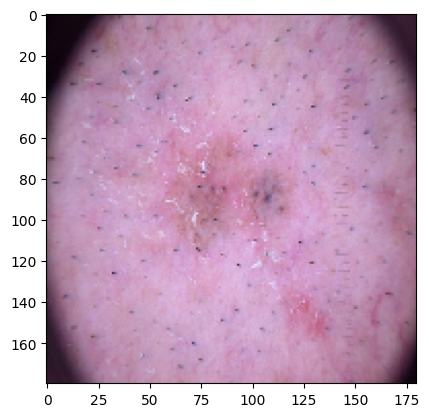

In [72]:
test_image_path = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(test_image_path)
test_image = load_img(test_image[-1],target_size=(180,180,3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)